---- CALL DEBIT SPREADS PORTFOLIO'S RISK QUANTIFICATION ----<br><br>
The main objective of this notebook is to find out the probability of the maximum downfall on a Call Debit Spread portfolio at one given time, i.e., if 10% of the entire account is dedicated to the Call Debit Spread strategy, what is the probability that the entire portfolio is in such a loss that the 10% loss occurre, resulting in neccessity of closing all the positions at once and the account suffering the 10% loss.

---- Objectives of Call Debit Spreads Portfolio's Risk ----<br>
1. Calculate the initial probabilities considering that each CDS position is opened with 1% of the entire account.
2. Optimize the percentual size of each CDS position to minimize the probability of default, i.e., reaching 10% loss on the entire account.
3. How does these probabilities change in continuous time when some CDS positions end up profitable (adding to the account) and new are opened.

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
YEARS_TO_EXP = 2
PREMATURE_PERC_PROFIT = 0.35
PREMATURE_PERC_LOSS = -0.5

In [254]:
def calculate_call_option_price(S, K, sigma, T, r):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)      
    return call_price

def calculate_historical_volatility(histrorical_volatility_data):
    sum_squared_returns = histrorical_volatility_data["log_returns_squared"].sum()
    n = histrorical_volatility_data["log_returns"].count()
    sigma_historical = np.sqrt((252 / n) * sum_squared_returns)
    return round(sigma_historical, 6)

In [ ]:
class ModelARIMA():

      def __init__(self) -> None:
            pass

      def hyndman_khandakar(self, series):
            auto_model = auto_arima(series)
            #forecast, conf_int = auto_model.predict(n_periods=1, return_conf_int=True, alpha=0.05)
            #conf_int = conf_int[0]
            order = list(auto_model.order)
            seasonal_order = list(auto_model.seasonal_order)
            parameters = []
            parameters.append(order)
            parameters.append(seasonal_order)
            return parameters
      
      def check_stationarity(self, data):
            result = adfuller(data)
            if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
                  return True
            else:
                  return False
        
      def invert_differencing(self, forecast, differencing_count, data):
            reverted = forecast
            for i in range(1, differencing_count + 1):
                  reverted = reverted.cumsum() + data.iloc[-i]
            return reverted

      def arima_model(self, series, parameters):
            order = tuple(parameters[0])
            seasonal_order = tuple(parameters[1])
            model = sm.tsa.statespace.SARIMAX(series, order=order, seasonal_order=seasonal_order, trend="c")
            res = model.fit(disp=False)
            forecast = res.get_prediction(steps=1)
            expected = forecast.predicted_mean.values[0]
            conf_int = forecast.conf_int(alpha=0.05).values.tolist()[0]
            return expected, conf_int

      def get_parameters(self, data):
            close_p = data["Close"]

            is_data_stationary = self.check_stationarity(close_p)
            while is_data_stationary == False:
                  close_p = close_p.diff()
                  close_p = close_p.dropna()
                  is_data_stationary = self.check_stationarity(close_p)

            parameters = self.hyndman_khandakar(close_p)
            return parameters
      
      def model(self, data, parameters):
            #data = data.sort_values(by="Date", ascending=True)
            close_p = data
            differencing_count = 0
            is_data_stationary = self.check_stationarity(close_p)
            while is_data_stationary == False:
                  close_p = close_p.diff()
                  close_p = close_p.dropna()
                  differencing_count += 1
                  is_data_stationary = self.check_stationarity(close_p)

            forecast, conf_int = self.arima_model(close_p, parameters)

            conf_int = np.array(conf_int, ndmin=2)  
            forecast = pd.Series(forecast)

            forecast = self.invert_differencing(forecast, differencing_count, data)
            conf_int[:, 0] = self.invert_differencing(conf_int[:, 0], differencing_count, data)
            conf_int[:, 1] = self.invert_differencing(conf_int[:, 1], differencing_count, data)

            return forecast, conf_int


In [11]:
class CDSPortfolioRiskBacktest():


    def __init__(self):
        self.data, self.files = self.load_data()
        self.all_dates = pd.to_datetime(
            pd.concat([df["Date"] for df in self.data.values()])
        ).drop_duplicates().sort_values().reset_index(drop=True)
        self.all_dates = self.extract_considered_dates()
        self.portfolio = pd.DataFrame(columns=["asset", "expiration", "long_strike", "short_strike", "long_price", "short_price", "spread_cost", 
             "max_profit", "position_size", "contracts_bought"])
        self.account_size = 100000 # $100'000
        # This means we can open with max of 0.6%, i.e., we can open up to 3 positions and not loosing more than 1% if we close them all with 50% loss
        self.trade_size = self.account_size * 0.006
        self.all_portfolio_backtests = []
        self.log = []

    def extract_considered_dates(self):
        min_considered_date = portfolio_risk_backtest.all_dates.iloc[0] + pd.DateOffset(years=1)
        max_considered_date = portfolio_risk_backtest.all_dates.iloc[-1] - pd.DateOffset(years=2)
        considered_dates = self.all_dates[
            (self.all_dates >= min_considered_date) &
            (self.all_dates <= max_considered_date)
        ]
        return considered_dates


    def load_data(self):
        data_folder_path = "./../data"
        files = os.listdir(data_folder_path)
        files = [f for f in files if os.path.isfile(os.path.join(data_folder_path, f))]
        data = {}
        for filename in os.listdir(data_folder_path):
            if filename.endswith(".csv"):
                filepath = os.path.join(data_folder_path, filename)
                df = pd.read_csv(filepath)
                data[filename] = df
        return data, files
    

    def get_proxy_implied_volatility(self, date, asset):
        pass
    

    def check_opened_positions(self, date, portfolio_pnl):
        for index, row in self.portfolio.iterrows():
            price = self.data.loc[self.data["Date"] == date, "Close"].item()
            step_sigma, _ = self.get_proxy_implied_volatility()
            


    def check_observed_underlying_assets(self, date):
        #pass
        for asset in self.files:
            price = portfolio_risk_backtest.data[asset].query(f'Date == "{date}"')["Close"].item()
            ma50_level = portfolio_risk_backtest.data[asset].query(f'Date == "{date}"')["50_day_MA"].item()
            ma100_level = portfolio_risk_backtest.data[asset].query(f'Date == "{date}"')["100_day_MA"].item()
            condition = (
                (ma50_level > ma100_level) and
                (price < ma50_level) and
                ((date + pd.DateOffset(years=2)) >= self.data["Date"].max())
            )
            if condition == True:
                step_sigma, series = self.get_proxy_implied_volatility()
                spreads = self.get_spreads(series, date, step_sigma, asset, price)
                try:
                    random_spread = spreads.sample(n=1)
                    spread_cost = random_spread["spread_cost"].item()
                    number_of_contracts = round(self.trade_size / (spread_cost * 100))
                    position_cost = spread_cost * 100 * number_of_contracts
                    current_allocation = self.portfolio.loc[self.portfolio["asset"] == asset, "position_size"].sum()
                    max_allocation = self.account_size * 0.01

                    # Some spreads are too expensive they cannot be bought with the current account size
                    # or its portion dedicated to Call Debit Spreads + 
                    if (number_of_contracts > 0) and ((current_allocation + position_cost) < max_allocation):
                        random_spread["position_size"] = position_cost
                        random_spread["contracts_bought"] = number_of_contracts
                        self.portfolio = pd.concat([self.portfolio, random_spread], ignore_index=True)
                except Exception as e:
                    #self.log.append(e)
                    continue
    
    
    def backtest_portfolio_risk(self):
        portfolio_pnl = [0]
        for date in self.all_dates:
            portfolio_pnl = self.check_opened_positions(date, portfolio_pnl)
            self.check_observed_underlying_assets(date)

        portfolio_pnl = [x * 100 for x in portfolio_pnl]
        self.all_portfolio_backtests.append(portfolio_pnl)
        # Portfolio should be empty at the end of each simulation
        #if len(self.portfolio) != 0:
        #    self.log.append(f"Error on {}")
    

    
    
portfolio_risk_backtest = CDSPortfolioRiskBacktest()

asset_data = portfolio_risk_backtest.data["qqq_data.csv"]
asset_data[
            (asset_data["Date"] <= pd.to_datetime("2025-07-10")) &
            (asset_data["Date"] >= (pd.to_datetime("2025-07-10") - pd.DateOffset(years=1)))
        ]["Close"]

#asset_data = portfolio_risk_backtest.data["qqq_data.csv"]
#asset_data[asset_data["Date"] == "2015-07-20"]["Close"].item()
#date = "2015-07-20"
#portfolio_risk_backtest.data["qqq_data.csv"].query(f'Date == "{date}"')["Close"].item()


IndexError: single positional indexer is out-of-bounds

In [524]:
class CDSPortfolioGBMSimulation():

    def __init__(self):
        self.M = 110 # Number of simulations
        self.sim_years = 4
        self.sim_years_steps = self.sim_years * 365 # Number of steps in trading days per year
        self.data, self.files = self.load_data()
        self.portfolio_gbm, self.portfolio_50ma, self.portfolio_100ma = self.simulate_portfolio_price_paths()
        self.observed_assets = self.load_observed_assets()

    def load_data(self):
        data_folder_path = "./../data"
        files = os.listdir(data_folder_path)
        files = [f for f in files if os.path.isfile(os.path.join(data_folder_path, f))]
        data = {}
        for filename in os.listdir(data_folder_path):
            if filename.endswith(".csv"):
                filepath = os.path.join(data_folder_path, filename)
                df = pd.read_csv(filepath)
                data[filename] = df
        return data, files
    
    def load_observed_assets(self):
        pass
        #return observed_assets
    
    def simulate_portfolio_price_paths(self):
        portfolio_gbm = {}
        portfolio_50ma = {}
        portfolio_100ma = {}

        for asset in self.files:
            asset_data = self.data[asset]
            asset_data["Date"] = pd.to_datetime(asset_data["Date"])
            one_year_ago = asset_data["Date"].iloc[-1] - pd.Timedelta(days=365)
            last_year_data = asset_data[asset_data["Date"] >= one_year_ago]
            S0 = last_year_data["Close"].iloc[-1]
            mu = np.mean(last_year_data["Log_return"]) * 365
            sigma = np.std(last_year_data["Log_return"], ddof=1) * np.sqrt(365)
            dt = self.sim_years / self.sim_years_steps # Calculate each time step

            St = np.exp(
                (mu - sigma ** 2 / 2) * dt
                + sigma * np.random.normal(0, np.sqrt(dt), size=(self.M, self.sim_years_steps)).T
            )
            St = np.vstack([np.ones(self.M), St])
            St = S0 * St.cumprod(axis=0)

            steps, simulations = St.shape
            Ma_50 = np.full((steps, simulations), np.nan)
            Ma_100 = np.full((steps, simulations), np.nan)

            window_50 = 50
            weights_50 = np.ones(window_50) / window_50

            window_100 = 100
            weights_100 = np.ones(window_100) / window_100

            for i in range(simulations):
                # Compute valid part
                valid_ma_50 = np.convolve(St[:, i], weights_50, mode="valid")
                valid_ma_100 = np.convolve(St[:, i], weights_100, mode="valid")
                
                # Fill result (pad initial values with NaN)
                Ma_50[window_50 - 1:, i] = valid_ma_50
                Ma_100[window_100 - 1:, i] = valid_ma_100

            portfolio_gbm[asset] = St
            portfolio_50ma[asset] = Ma_50
            portfolio_100ma[asset] = Ma_100

        return portfolio_gbm, portfolio_50ma, portfolio_100ma
    

In [734]:
class CDSPortfolioMCSimulation():

    def __init__(self, sim_num):
        self.simulated_portfolio = CDSPortfolioGBMSimulation()
        self.model = ModelARIMA()
        self.portfolio = pd.DataFrame(columns=["asset", "expiration", "long_strike", "short_strike", "long_price", "short_price", "spread_cost", 
             "max_profit", "position_size", "contracts_bought"])
        self.account_size = 100000 # $100'000
        # This means we can open with max of 0.6%, i.e., we can open up to 3 positions and not loosing more than 1% if we close them all with 50% loss
        self.trade_size = self.account_size * 0.006
        self.number_of_simulations = sim_num
        self.log = []
        self.all_portfolio_simulations = []

    def calculate_call_option_price(self, S, K, sigma, T, r):
        d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)      
        return call_price

    def calculate_historical_volatility(self, histrorical_volatility_data):
        sum_squared_returns = histrorical_volatility_data["log_returns_squared"].sum()
        n = histrorical_volatility_data["log_returns"].count()
        sigma_historical = np.sqrt((252 / n) * sum_squared_returns)
        return round(sigma_historical, 6)

    def get_proxy_implied_volatility(self, gbm_path, step, asset):
        # If 252 steps (trading days) is deducted from the current step, but there isn't enough steps/days in the GBM simulation,
        # the start of the interval is from non-existing index, so the series is empty
        series = self.simulated_portfolio.portfolio_gbm[asset][step - 252:step, gbm_path]
        if len(series) == 0:
            missing_steps = abs(step - 252)
            series = np.concatenate([
                self.simulated_portfolio.data[asset]["Close"][-missing_steps:].to_numpy(),
                self.simulated_portfolio.portfolio_gbm[asset][0:step, gbm_path]
            ])
        series = pd.Series(series)
        volatility_data = pd.DataFrame()
        volatility_data["log_returns"] = np.log(series / series.shift(1))
        volatility_data["log_returns_squared"] = volatility_data["log_returns"] ** 2
        step_sigma = self.calculate_historical_volatility(volatility_data)
        return step_sigma, series
    
    def get_spreads(self, series, step, step_sigma, asset, price) -> DataFrame:
        _, conf_int = self.model.model(series, [[1, 0, 1], [0, 0, 0, 0]])
        strike_list_lower_boundary = round(round(conf_int[0][0]))
        strike_list_upper_boundary = round(round(conf_int[0][1]))
        strike_prices_list = [strike for strike in range(strike_list_lower_boundary, strike_list_upper_boundary + 1)]
        strike_price_chain = {
            "strike": strike_prices_list,
            "price": np.full(len(strike_prices_list), None),
            "implied_volatility": np.full(len(strike_prices_list), step_sigma)
        }
        strike_price_chain = pd.DataFrame(strike_price_chain)
        strike_price_chain["price"] = strike_price_chain.apply(
            lambda row: pd.Series(
                self.calculate_call_option_price(
                    price,
                    row["strike"],
                    step_sigma,
                    YEARS_TO_EXP,
                    self.simulated_portfolio.data[asset]["Risk-free Rate"].iloc[-1]
                )
            ),
            axis=1
        )
        spreads = []
        for _, long_call in strike_price_chain.iterrows():
            for _, short_call in strike_price_chain.iterrows():
                spread_cost = long_call["price"] - short_call["price"]
                max_profit = short_call["strike"] - long_call["strike"] - spread_cost

                spreads.append({
                    "asset": asset,
                    "expiration": step + 365 * YEARS_TO_EXP, # Is there enough room for it?
                    "long_strike": long_call["strike"],
                    "short_strike": short_call["strike"],
                    "long_price": long_call["price"],
                    "short_price": short_call["price"],
                    "spread_cost": spread_cost,
                    "max_profit": max_profit
                })
        spreads = pd. DataFrame(spreads)
        spreads = spreads[
            (spreads["long_strike"] < spreads["short_strike"]) &
            (spreads["short_strike"] > price)
        ] # Only OTM spreads
        spreads = spreads[spreads["max_profit"] > spreads["spread_cost"]]
        return spreads
        

    def check_opened_positions(self, gbm_path, step, portfolio_pnl):
        for index, row in self.portfolio.iterrows():
            price = self.simulated_portfolio.portfolio_gbm[row["asset"]][step, gbm_path]
            step_sigma, _ = self.get_proxy_implied_volatility(gbm_path, step, row["asset"])
            # For consistency, datasets of underlying assets should be created on the same day, so the risk-free rates are same for the modelling
            r = self.simulated_portfolio.data[row["asset"]]["Risk-free Rate"].iloc[-1]
            time_to_expiration = (row["expiration"] - step) / 365
            long_call_price = calculate_call_option_price(price, row["long_strike"], step_sigma, time_to_expiration, r)
            short_call_price = calculate_call_option_price(price, row["short_strike"], step_sigma, time_to_expiration, r)
            spread_value = long_call_price - short_call_price
            spread_return = (spread_value - row["spread_cost"]) / row["spread_cost"]
            
            if (spread_return >= PREMATURE_PERC_PROFIT) and (row["expiration"] - step) <= 100:
                profit_in_usd = row["max_profit"] * PREMATURE_PERC_PROFIT * row["contracts_bought"]
                portfolio_pnl.append(portfolio_pnl[-1] + profit_in_usd)
                self.portfolio = self.portfolio.drop(index=index)

            if spread_return <= PREMATURE_PERC_LOSS and (row["expiration"] - step) <= 100:
                loss_in_usd = row["spread_cost"] * PREMATURE_PERC_LOSS * row["contracts_bought"]
                portfolio_pnl.append(portfolio_pnl[-1] + loss_in_usd)
                self.portfolio = self.portfolio.drop(index=index)

            if row["expiration"] == step:
                if price > row["short_strike"]:
                    profit_in_usd = row["max_profit"] * row["contracts_bought"]
                    portfolio_pnl.append(portfolio_pnl[-1] + profit_in_usd)
                    self.portfolio = self.portfolio.drop(index=index)
                elif price < row["long_strike"]:
                    loss_in_usd = row["spread_cost"] * row["contracts_bought"]
                    portfolio_pnl.append(portfolio_pnl[-1] + loss_in_usd)
                    self.portfolio = self.portfolio.drop(index=index)
                else:
                    portfolio_pnl.append(portfolio_pnl[-1] + spread_return * row["max_profit"] * row["contracts_bought"])
                    self.portfolio = self.portfolio.drop(index=index)

        return portfolio_pnl

    def check_observed_underlying_assets(self, gbm_path, step):
        for asset in self.simulated_portfolio.files:
            price = self.simulated_portfolio.portfolio_gbm[asset][step, gbm_path]
            ma50_level = self.simulated_portfolio.portfolio_50ma[asset][step, gbm_path]
            ma100_level = self.simulated_portfolio.portfolio_100ma[asset][step, gbm_path]

            condition = (
                (ma50_level > ma100_level) and
                (price < ma50_level) and
                ((self.simulated_portfolio.sim_years_steps - step) > (365 * 2)) #and # There must be at least two years available in the future steps of the simulation
                # This needs to be uncomented once I start simulating
                #(asset not in portfolio["asset"].values) # Returning single True/False based on whether the asset is already in the portfolio or not
            )

            if condition == True:
                step_sigma, series = self.get_proxy_implied_volatility(gbm_path, step, asset)
                spreads = self.get_spreads(series, step, step_sigma, asset, price)
                # There were no spreads because early 50-days and 100-days Moving Averages had Nan values
                try:
                    random_spread = spreads.sample(n=1)
                    spread_cost = random_spread["spread_cost"].item()
                    number_of_contracts = round(self.trade_size / (spread_cost * 100))
                    position_cost = spread_cost * 100 * number_of_contracts
                    current_allocation = self.portfolio.loc[self.portfolio["asset"] == asset, "position_size"].sum()
                    max_allocation = self.account_size * 0.01

                    # Some spreads are too expensive they cannot be bought with the current account size
                    # or its portion dedicated to Call Debit Spreads + 
                    if (number_of_contracts > 0) and ((current_allocation + position_cost) < max_allocation):
                        random_spread["position_size"] = position_cost
                        random_spread["contracts_bought"] = number_of_contracts
                        self.portfolio = pd.concat([self.portfolio, random_spread], ignore_index=True)
                except Exception as e:
                    #self.log.append(e)
                    continue

    def run_monte_carlo_simulation(self):
        for _ in range(self.number_of_simulations):
            portfolio_pnl = [0]
            gbm_path = random.randint(0, self.simulated_portfolio.M - 1) # Number of GBM simulations passed from CDSPortfolioGBMSimulation class
            for step in range(self.simulated_portfolio.sim_years_steps): # Number of steps in GBM paths passed from CDSPortfolioGBMSimulation class
                # Checking the currently opened Call Debit Spread positions whether they are to be closed or exercised
                # Randomly selected GBM path for each simulation and time step on it are passed to the method
                portfolio_pnl = self.check_opened_positions(gbm_path, step, portfolio_pnl)
                # Checking the all observed underlying asset at each step whether the condition for opening Call Debit Spread position occured
                # Randomly selected GBM path for each simulation and time step on it are passed to the method
                self.check_observed_underlying_assets(gbm_path, step)

            portfolio_pnl = [x * 100 for x in portfolio_pnl]
            self.all_portfolio_simulations.append(portfolio_pnl)
            # Portfolio should be empty at the end of each simulation
            if len(self.portfolio) != 0:
                self.log.append(f"Error on {gbm_path}")

        return self.all_portfolio_simulations
    
# Object for CDS portfolio Monte Carlo simluation
mc_simulation = CDSPortfolioMCSimulation(100)
                

In [735]:
print("**** Tests before CDS Portfolio's Default Risk Simulation ****")

def were_all_gbm_paths_created(mc_simulation):
    # Getting indexes of random paths, the count of indexes is equal to number of observed underlying assets
    random_paths = random.sample(range(0, mc_simulation.simulated_portfolio.M), len(mc_simulation.simulated_portfolio.files))
    results = []
    for file, path in zip(mc_simulation.simulated_portfolio.files, random_paths):
        if (len(mc_simulation.simulated_portfolio.portfolio_gbm[file][path]) == mc_simulation.simulated_portfolio.M) and \
           (len(mc_simulation.simulated_portfolio.portfolio_50ma[file][path]) == mc_simulation.simulated_portfolio.M) and \
           (len(mc_simulation.simulated_portfolio.portfolio_100ma[file][path]) == mc_simulation.simulated_portfolio.M):
            results.append(True)
    # If all combinations of underlying assets and their GBM paths passed the test
    if all(results):
        return "PASS"
    return "FAIL"

def were_all_steps_within_gbm_created(mc_simulation):
    results = []
    for file in mc_simulation.simulated_portfolio.files:
        if (len(mc_simulation.simulated_portfolio.portfolio_gbm[file]) == mc_simulation.simulated_portfolio.sim_years_steps) and \
           (len(mc_simulation.simulated_portfolio.portfolio_50ma[file]) == mc_simulation.simulated_portfolio.sim_years_steps) and \
           (len(mc_simulation.simulated_portfolio.portfolio_100ma[file]) == mc_simulation.simulated_portfolio.sim_years_steps):
            results.append(True)
    if all(results):
        return "PASS"
    return "FAIL"

print(f"1. Each observed underlying asset has {mc_simulation.simulated_portfolio.M} simulated price paths as well as 50-days and 100-days Moving Averages related to these price paths: {were_all_gbm_paths_created(mc_simulation)}")
print(f"2. Each observed underlying asset has via-GBM simulated price paths and 50-days and 100-days Moving Averages of length {mc_simulation.simulated_portfolio.sim_years_steps}: {were_all_steps_within_gbm_created(mc_simulation)}")



**** Tests before CDS Portfolio's Default Risk Simulation ****
1. Each observed underlying asset has 110 simulated price paths as well as 50-days and 100-days Moving Averages related to these price paths: PASS
2. Each observed underlying asset has via-GBM simulated price paths and 50-days and 100-days Moving Averages of length 1460: PASS


In [736]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

all_portfolio_simulations = mc_simulation.run_monte_carlo_simulation()

/var/folders/0k/vksjbls10m9f1y5tjj3t5gh40000gn/T/ipykernel_38486/3980219223.py:160: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.portfolio = pd.concat([self.portfolio, random_spread], ignore_index=True)


KeyboardInterrupt: 

In [727]:
all_portfolio_simulations = [sim[1:] for sim in all_portfolio_simulations]

In [730]:
flat_simulations = np.concatenate(all_portfolio_simulations)

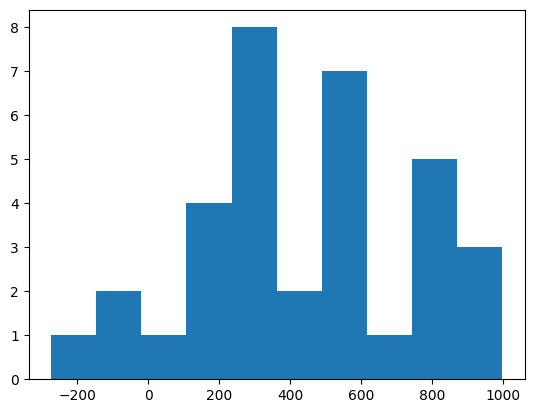

In [733]:
plt.hist(flat_simulations, bins=10)
plt.show()